# Usporedba ljudskog, Edgarovog automatskog i LLM ocjenjivanja studentskih rješenja

## Uvod

Tema ovog projekta bavi se usporedbom triju pristupa ocjenjivanju studentskih radova; ljudskog, Edgarovog automatskog i onog temeljenog na velikim jezičnim modelima (LLM). Poseban naglasak stavlja se na potencijal LLM-a da kombinira prednosti ljudskog prosuđivanja i automatizirane obrade.  

Tradicionalno ljudsko ocjenjivanje studentskih radova omogućuje uvažavanje rješenja koja ne slijede standardne obrasce, jednostavno parcijalno bodovanje rješenja koja ne dovode do točnog rezultata, ali koriste djelomično točan postupak, te kaznu rješenja koja dolaze do točnog odgovora na nepoželjan način. Glavni nedostatci su velika vremenska zahtjevnost i potreba za većim brojem kvalificiranih ocjenjivača, kao i subjektivnost ocjenjivača, koja se može djelomično ublažiti postavljanjem kriterija ocjenjivanja.  

Automatsko ocjenjivanje omogućuje brzo i konzistentno ocjenjivanje, ali je često teško postići fleksibilnost koju pruža ljudski ocjenjivač.  

U okviru ovog projekta fokus je na ocjenjivanju jednostavnih studentskih programskih rješenja namijenjenih rješavanju specifičnih problema, konkretno zadataka s kolegija "Uvod u programiranje". Studentska rješenja trenutačno se provjeravaju automatski putem sustava Edgar, koji ispituje točnost izlaza za unaprijed definirane ulaze, te naknadno ljudskom provjerom kojom se procjenjuje i boduje rješenje.  

U posljednje vrijeme LLM-ovi postižu napredak u razumijevanju jezika i koda, što otvara mogućnost njihove primjene i u ocjenjivanju studentskih programskih rješenja.  

## Cilj projekta

Cilj projekta je provesti kvantitativnu i kvalitativnu usporednu analizu između ljudskog, automatskog i LLM pristupa ocjenjivanja studentskih programskih rješenja. U tu svrhu odabrana su dva LLM-a te su osmišljeni upiti koji će davati poželjne odgovore na studentska rješenja zadataka.  

___

# Učitavanje i čišćenje podataka

U ovoj sekciji učitavamo glavnu dataset datoteku `studentTestQuestion.csv`, 
koja sadrži podatke o automatskom (Edgar) i ručnom (manualnom) ocjenjivanju 
studentskih programskih rješenja.

Zatim pripremamo podatke za daljnju analizu. Provjeravamo tipove podataka, konvertiramo numeričke stupce i uklanjamo redove koji nemaju stvarno manualno ocjenjivanje.
Također bilježimo broj nedostajućih vrijednosti po stupcu kako bismo imali pregled kvalitete podataka prije statističkih analiza.




In [32]:
import pandas as pd
import numpy as np

# Učitavanje CSV-a
df = pd.read_csv("studentTestQuestion.csv", sep='\t', engine='python')

print(f"Dimenzije podataka (redovi, stupci): {df.shape}")
print("Nazivi stupaca:")
print(df.columns.tolist())
print("\nPrvih 5 redova:")
display(df.head())

# Provjera tipova i konverzija numeričkih stupaca
numeric_cols = [
    'test_max_score', 'test_score_ed', 'test_score_man',
    'test_score_perc_ed', 'test_score_perc_man',
    'question_score_ed', 'question_score_man',
    'question_score_perc_ed', 'question_score_perc_man',
    'diff_perc'
]

for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

print("\nTipovi podataka nakon konverzije:")
print(df.dtypes)

# Uklanjanje redaka bez stvarnog manualnog ocjenjivanja
# Pravilo: question_score_man == 0 i id_app_user == 0 ili NaN
condition_no_manual = (
    (df['question_score_man'] == 0) &
    ((df['id_app_user'] == 0) | (df['id_app_user'].isna()))
)
removed_count = condition_no_manual.sum()
print(f"\nBroj redaka bez stvarnog manualnog ocjenjivanja: {removed_count}")

df = df[~condition_no_manual]
print(f"Dimenzije nakon uklanjanja: {df.shape}")

# Provjera nedostajućih vrijednosti
print("\nBroj nedostajućih vrijednosti po stupcu:")
display(df.isna().sum())

print("\nOpisna statistika numeričkih stupaca:")
display(df[numeric_cols].describe())


Dimenzije podataka (redovi, stupci): (6708, 18)
Nazivi stupaca:
['id_test', 'id_test_instance', 'id_academic_year', 'title', 'id_student', 'test_max_score', 'test_score_ed', 'test_score_man', 'test_score_perc_ed', 'test_score_perc_man', 'id_question', 'student_answer_code', 'id_app_user', 'question_score_ed', 'question_score_man', 'question_score_perc_ed', 'question_score_perc_man', 'diff_perc']

Prvih 5 redova:


,id_test,id_test_instance,id_academic_year,title,id_student,test_max_score,test_score_ed,test_score_man,test_score_perc_ed,test_score_perc_man,id_question,student_answer_code,id_app_user,question_score_ed,question_score_man,question_score_perc_ed,question_score_perc_man,diff_perc
0,14530,332559,2023,Završni ispit 2023/24 - drugi termin,10127,40.0,30.0,0.0,0.75,0.00,47999,\r\n\r\n\r\n\r\n#include <ctype.h>\r\n#include...,1176.0,10.0,0.0,1.0,0.0,1.0
1,14529,330776,2023,Završni ispit 2023/24 - prvi termin,8863,40.0,30.0,22.0,0.75,0.55,48002,"int k = 0;\r\n long long int polje[48] = {0, 1...",1030.0,10.0,0.0,1.0,0.0,1.0
2,14530,331780,2023,Završni ispit 2023/24 - drugi termin,9050,40.0,30.0,20.0,0.75,0.50,48011,#include <stdio.h>\r\n#include <stdlib.h>\r\n\...,1003.0,10.0,0.0,1.0,0.0,1.0
3,14530,332559,2023,Završni ispit 2023/24 - drugi termin,10127,40.0,30.0,0.0,0.75,0.00,48011,#include <stdio.h>\r\n#include <stdlib.h>\r\n\...,1176.0,10.0,0.0,1.0,0.0,1.0
4,14530,332559,2023,Završni ispit 2023/24 - drugi termin,10127,40.0,30.0,0.0,0.75,0.00,48019,\r\n\r\n\r\n\r\nint brojiDjelj3Kumulativno(int...,1176.0,10.0,0.0,1.0,0.0,1.0



Tipovi podataka nakon konverzije:
id_test                      int64
id_test_instance             int64
id_academic_year             int64
title                       object
id_student                   int64
test_max_score             float64
test_score_ed              float64
test_score_man             float64
test_score_perc_ed         float64
test_score_perc_man        float64
id_question                  int64
student_answer_code         object
id_app_user                float64
question_score_ed          float64
question_score_man         float64
question_score_perc_ed     float64
question_score_perc_man    float64
diff_perc                  float64
dtype: object

Broj redaka bez stvarnog manualnog ocjenjivanja: 4
Dimenzije nakon uklanjanja: (6704, 18)

Broj nedostajućih vrijednosti po stupcu:


id_test                     0
id_test_instance            0
id_academic_year            0
title                       0
id_student                  0
test_max_score              0
test_score_ed               0
test_score_man              0
test_score_perc_ed          0
test_score_perc_man         0
id_question                 0
student_answer_code        89
id_app_user                 6
question_score_ed           0
question_score_man          0
question_score_perc_ed      0
question_score_perc_man     0
diff_perc                   0
dtype: int64


Opisna statistika numeričkih stupaca:


,test_max_score,test_score_ed,test_score_man,test_score_perc_ed,test_score_perc_man,question_score_ed,question_score_man,question_score_perc_ed,question_score_perc_man,diff_perc
count,6704.000000,6704.000000,6704.000000,6704.000000,6704.000000,6704.000000,6704.000000,6704.000000,6704.000000,6704.000000
mean,44.439141,18.922640,21.876105,0.451487,0.519979,4.733550,5.472065,0.451978,0.520354,-0.068376
std,14.045233,13.596929,12.971587,0.310327,0.292478,5.349977,4.961450,0.479783,0.437763,0.232692
min,30.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000
25%,40.000000,10.000000,12.500000,0.250000,0.293000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,40.000000,20.000000,21.500000,0.500000,0.514000,0.000000,5.500000,0.000000,0.550000,0.000000
75%,40.000000,30.000000,30.000000,0.750000,0.750000,10.000000,10.000000,1.000000,1.000000,0.000000
max,70.000000,70.000000,70.000000,1.000000,1.000000,18.000000,18.000000,1.000000,1.000000,1.000000


#### Interpretacija

Proces uvoza i čišćenja podataka potvrdio je da je dataset visoke kvalitete i spreman za analizu:
* Minimalan gubitak podataka: Uklonjena su samo 4 retka koja nisu imala trag o manualnom ocjenjivanju, što znači da je gotovo cijeli početni skup podataka relevantan za usporedbu.
* Kompletnost ocjena: Svi ključni stupci s bodovima (Edgar i manualno) su u potpunosti popunjeni (0 nedostajućih vrijednosti), što osigurava stabilnu bazu za statističku usporedbu s LLM-om.
* Identificirani izazovi: Zabilježeno je 89 praznih rješenja (student_answer_code), što je važna informacija za fazu u kojoj ćemo LLM-u slati kod na evaluaciju, jer takvi primjeri zahtijevaju poseban tretman (automatska nula).

___

# Usporedba Edgarovog i manualnog ocjenjivanja

## 1) Osnovne metrike i usporedbe

U ovom odsječku izračunat ćemo i vizualizirati osnovne metrike razlika između Edgarovog i manualnog ocjenjivanja izražene kao postotci (diff_perc).
Vizualiziramo distribuciju razlika pomoću histograma i boxplota te provjeravamo eventualne outliere i osnovnu linearnu povezanost (regresija) između Edgarovih i manualnih ocjena.


Osnovne deskriptivne metrike (diff_perc):
Mean: -0.0684
Median: 0.0000
Std Dev: 0.2327
Min: -1.0000
Max: 1.0000


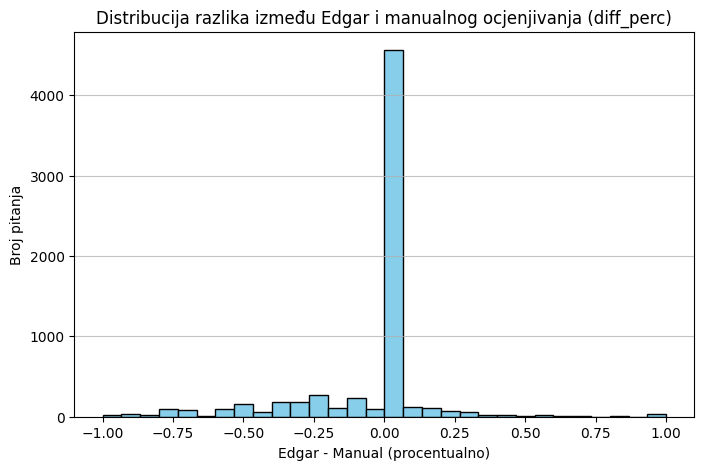

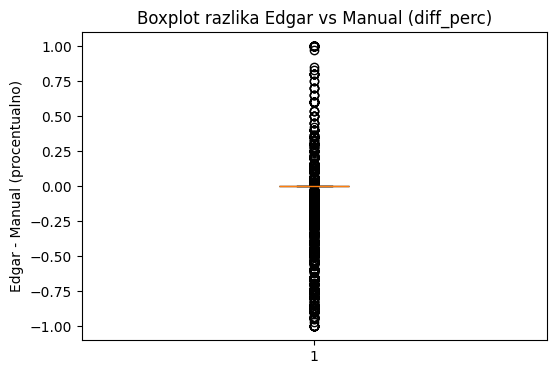

Broj outliera: 2216
Primjeri outliera:


0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
5    1.0
6    1.0
7    1.0
8    1.0
9    1.0
Name: diff_perc, dtype: float64


Linear regression: Manual = slope*Edgar + intercept
Slope: 0.7986, Intercept: 0.1594
R^2: 0.7662, p-value: 0.0000e+00


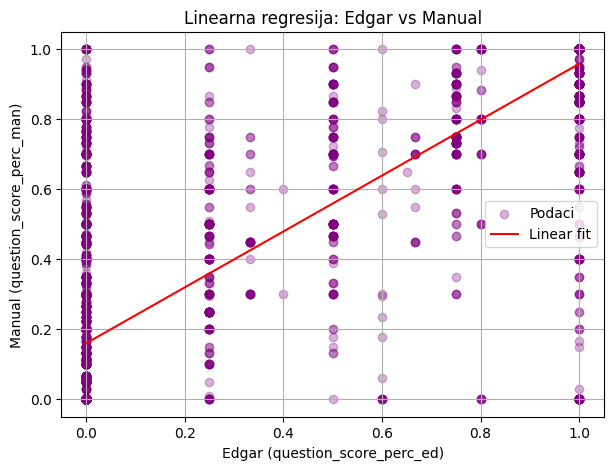

In [33]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

diff = df['diff_perc']  # diff_perc = question_score_perc_ed - question_score_perc_man

mean_diff = diff.mean()
median_diff = diff.median()
std_diff = diff.std()
min_diff = diff.min()
max_diff = diff.max()

print("Osnovne deskriptivne metrike (diff_perc):")
print(f"Mean: {mean_diff:.4f}")
print(f"Median: {median_diff:.4f}")
print(f"Std Dev: {std_diff:.4f}")
print(f"Min: {min_diff:.4f}")
print(f"Max: {max_diff:.4f}")

# --- Histogram ---
plt.figure(figsize=(8,5))
plt.hist(diff, bins=30, color='skyblue', edgecolor='black')
plt.title("Distribucija razlika između Edgar i manualnog ocjenjivanja (diff_perc)")
plt.xlabel("Edgar - Manual (procentualno)")
plt.ylabel("Broj pitanja")
plt.grid(axis='y', alpha=0.75)
plt.show()

# --- Boxplot ---
plt.figure(figsize=(6,4))
plt.boxplot(diff, vert=True, patch_artist=True, boxprops=dict(facecolor='lightgreen'))
plt.title("Boxplot razlika Edgar vs Manual (diff_perc)")
plt.ylabel("Edgar - Manual (procentualno)")
plt.show()

# --- Provjera outliera ---
q1 = diff.quantile(0.25)
q3 = diff.quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5*iqr
upper_bound = q3 + 1.5*iqr
outliers = diff[(diff < lower_bound) | (diff > upper_bound)]
print(f"Broj outliera: {len(outliers)}")
print("Primjeri outliera:")
display(outliers.head(10))

# --- Linearna regresija ---
edgar = df['question_score_perc_ed']
manual = df['question_score_perc_man']

slope, intercept, r_value, p_value, std_err = stats.linregress(edgar, manual)

print(f"\nLinear regression: Manual = slope*Edgar + intercept")
print(f"Slope: {slope:.4f}, Intercept: {intercept:.4f}")
print(f"R^2: {r_value**2:.4f}, p-value: {p_value:.4e}")

# Plot
plt.figure(figsize=(7,5))
plt.scatter(edgar, manual, alpha=0.3, color='purple', label='Podaci')
plt.plot(edgar, intercept + slope*edgar, color='red', label='Linear fit')
plt.xlabel("Edgar (question_score_perc_ed)")
plt.ylabel("Manual (question_score_perc_man)")
plt.title("Linearna regresija: Edgar vs Manual")
plt.legend()
plt.grid(True)
plt.show()


#### Interpretacija

* Negativna srednja vrijednost razlike (-0.0684) i regresijski presjek (intercept: 0.1594) potvrđuju da Edgar u prosjeku daje niže ocjene. Čak i kada Edgar dodijeli 0 bodova, ljudski ocjenjivači u prosjeku daju oko 16% bodova, što sugerira priznavanje parcijalne točnosti koju automatski sustav ne vidi.
* Visoka korelacija uz značajna odstupanja: Koeficijent determinacije ($R^2 = 0.7662$) ukazuje na snažnu povezanost, no brojni outlieri (2216) sugeriraju da u velikom broju slučajeva dolazi do potpunog razilaženja u procjeni.
* Histogram pokazuje izrazit vrh oko nule (podudaranje), ali i značajan broj rješenja gdje je razlika ekstremna. Upravo ovi ekstremni slučajevi, gdje Edgar i čovjek drastično različito vide kod.

## 2) Analiza po akademskoj godini

U ovom koraku analiziramo razlike između Edgarovog i manualnog ocjenjivanja (diff_perc) po akademskim godinama.
Cilj je otkriti jesu li neke godine “problematičnije”, jesu li ocjenjivači konzistentni unutar godine, te kako se razlikuju distribucije bodova.
Za svaku godinu vizualiziramo distribuciju diff_perc pomoću histograma i boxplota, provodimo Bland–Altman analizu, te prikazujemo tablicu srednjih razlika.

### Histogram po akademskoj godini

Histogram pokazuje raspodjelu razlika (diff_perc) unutar svake godine. Poželjno je vizualizirati da li su razlike između Edgarovog i manualnog ocjenjivanja ravnomjerno raspoređene ili postoje skupine/ekstremi.

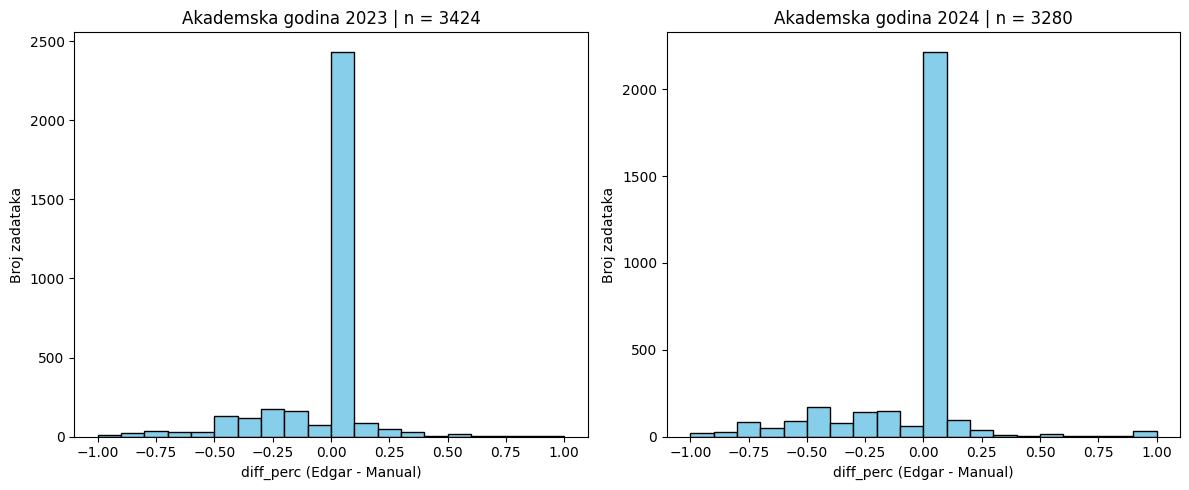

In [34]:
import matplotlib.pyplot as plt

years = sorted(df['id_academic_year'].dropna().unique())

fig, axes = plt.subplots(1, len(years), figsize=(6*len(years), 5))
if len(years) == 1:  # Ako je samo jedna godina, axes nije lista
    axes = [axes]

for ax, year in zip(axes, years):
    data_year = df[df['id_academic_year'] == year]['diff_perc']
    ax.hist(data_year, bins=20, color='skyblue', edgecolor='black')
    ax.set_title(f'Akademska godina {year} | n = {len(data_year)}')
    ax.set_xlabel('diff_perc (Edgar - Manual)')
    ax.set_ylabel('Broj zadataka')

plt.tight_layout()
plt.show()


#### Interpretacija

* Konzistentnost sustava: Distribucije su gotovo identične za obje godine, s dominantnim "šiljkom" na nuli. To znači da se u većini slučajeva Edgar i ljudi slažu, bez obzira na generaciju studenata ili težinu ispita u toj godini.

* Simetrija neslaganja: Vidljivo je da u obje godine postoji sličan postotak rješenja gdje ljudi daju više bodova od Edgara (lijeva strana grafa, negativne vrijednosti). Ovo sugerira da kriterij po kojem ljudi "opraštaju" pogreške koje Edgar kažnjava ostaje stabilan kroz vrijeme.

* Veličina uzorka: Uzorak je ravnomjerno raspoređen (3424 vs. 3280 zadataka), što daje visoku statističku težinu budućim zaključcima o LLM-u. Ako LLM uspije pogoditi ovaj "oblik" distribucije, moći ćemo reći da je uspješno usvojio opće kriterije ocjenjivanja kolegija.

### Boxplot po akademskoj godini

Boxplot prikazuje medijan, kvartile i outliere diff_perc po godinama. Pomaže da se odmah vizualno uoče ekstremi i opseg razlika.

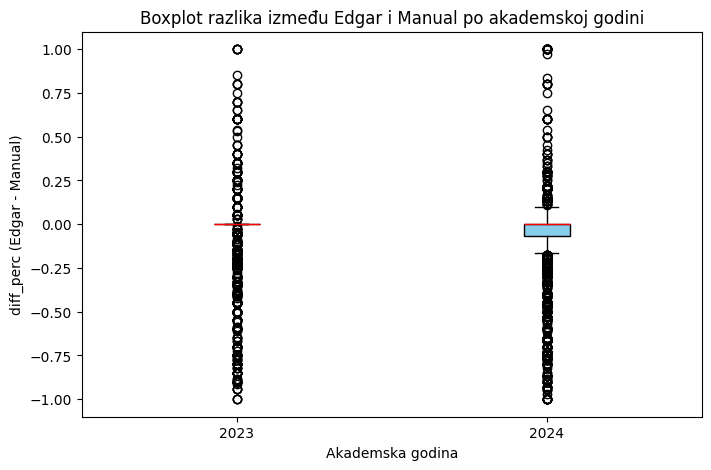

In [35]:
import matplotlib.pyplot as plt

years = sorted(df['id_academic_year'].dropna().unique())
data_by_year = [df[df['id_academic_year']==year]['diff_perc'] for year in years]

plt.figure(figsize=(8,5))
plt.boxplot(
    data_by_year, 
    tick_labels=years,  # <--- promijenjeno
    patch_artist=True,
    boxprops=dict(facecolor='skyblue', color='black'),
    medianprops=dict(color='red'),
    whiskerprops=dict(color='black'),
    capprops=dict(color='black')
)


plt.title('Boxplot razlika između Edgar i Manual po akademskoj godini')
plt.xlabel('Akademska godina')
plt.ylabel('diff_perc (Edgar - Manual)')
plt.show()


#### Interpretacija

Boxplot analiza potvrđuje da se obrasci odstupanja ne mijenjaju značajno između generacija, ali naglašava prisutnost ekstremnih razlika:
* Identičan medijan: Medijan razlike čvrsto stoji na nuli u obje godine, što znači da je za tipičnog studenta automatizirano ocjenjivanje slično ljudskom.
* Asimetrija outliera: Vidljiv je velik broj outliera na oba ekstremna kraja (razlika od -1.0 i +1.0). Donji outlieri (ispod -0.5) su posebno zanimljivi jer predstavljaju situacije gdje Edgar ne priznaje ništa, dok čovjek rješenje ocjenjuje visokom ocjenom; sugerira da postoje specifični tipovi programskih pogrešaka koje Edgar sustavno "kažnjava", a ljudi sustavno "opraštaju
* Konzistentnost kriterija: Usprkos promjenama u zadacima ili studentima, raspon "kutije" (interkvartilni raspon) ostaje vrlo sličan, što ukazuje na to da su ljudski ocjenjivači razvili stabilan i predvidljiv sustav korekcije Edgarovih rezultata.

### 2D density plot po akademskoj godini

U ovom dijelu prikazujemo 2D gustosni (dense) plot za odnos bodova koje je dao Edgar i bodova koje je dao manualni ocjenjivač, po akademskoj godini.
* X-os: question_score_perc_ed (Edgar)
* Y-os: question_score_perc_man (manualno)

Boja označava gustoću pojavljivanja točaka.

Ovaj pristup je posebno koristan kada imamo puno podataka, jer scatter plot može biti pretrpan. Dense plot omogućuje vizualno uočavanje regija gdje se ocjene slažu i gdje postoje značajnije razlike, a može nam i pomoći u prepoznavanju outliera.

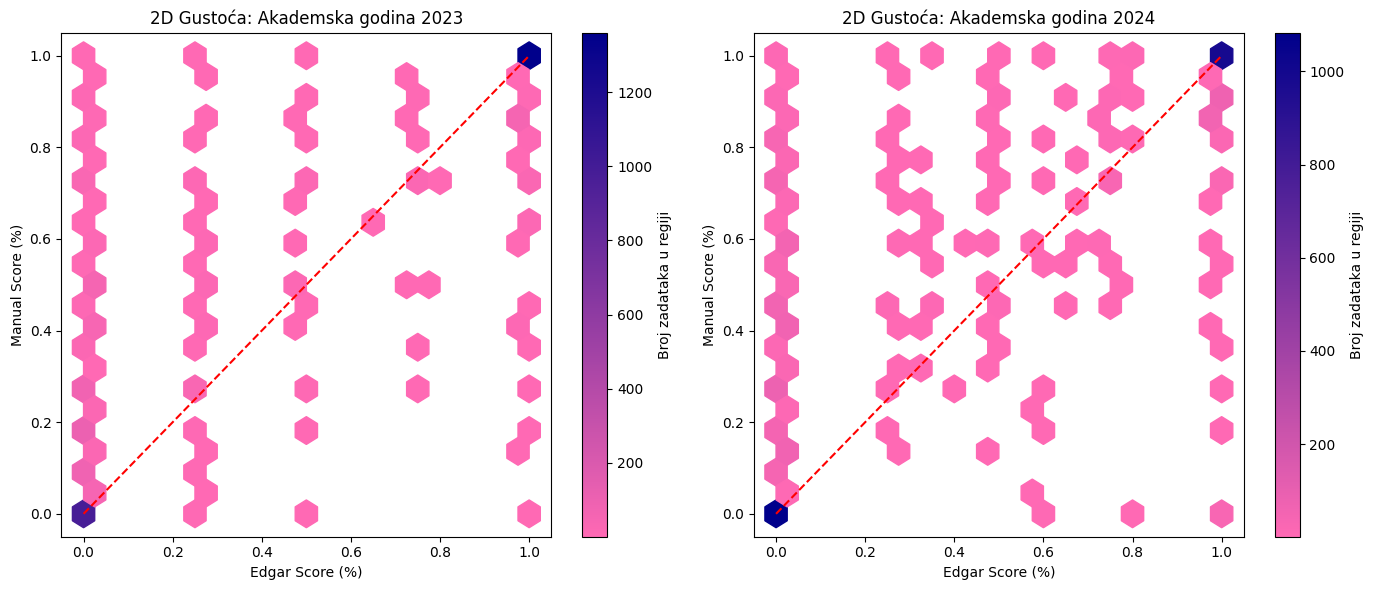

In [36]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# 1. Definiramo vlastitu paletu boja: 
# Krećemo od 'hotpink' (obična roza) do 'darkblue' (tamno plava)
colors = ["hotpink", "darkblue"]
custom_pink_blue = LinearSegmentedColormap.from_list("custom_pink", colors)

years = sorted(df['id_academic_year'].unique())
fig, axes = plt.subplots(1, len(years), figsize=(14, 6))

if len(years) == 1:
    axes = [axes]

for ax, year in zip(axes, years):
    subset = df[df['id_academic_year'] == year]
    
    # Koristimo custom_pink_blue umjesto stare palete
    hb = ax.hexbin(subset['question_score_perc_ed'], 
                   subset['question_score_perc_man'], 
                   gridsize=20, 
                   cmap=custom_pink_blue, # Ovdje ide nova boja
                   mincnt=1)
    
    ax.plot([0, 1], [0, 1], color='red', linestyle='--', label='Savršeno slaganje')
    
    ax.set_title(f'2D Gustoća: Akademska godina {year}')
    ax.set_xlabel('Edgar Score (%)')
    ax.set_ylabel('Manual Score (%)')
    
    cb = fig.colorbar(hb, ax=ax)
    cb.set_label('Broj zadataka u regiji')

plt.tight_layout()
plt.show()

#### Interpertacija

* Najveća gustoća (tamnoplave regije) nalazi se u točkama (0,0) i (1,1). To potvrđuje da se Edgar i ljudi slažu u ekstremnim slučajevima; kada je kod potpuno nefunkcionalan ili potpuno točan.
* Tamniji šesterokuti koji se protežu vertikalno uzduž Y-osi iznad Edgarove nule (X=0) su kritični slučajevi gdje Edgar dodjeljuje 0%, a ljudi daju između 20% i 80% bodova.
* Prostor ispod crvene isprekidane linije je gotovo prazan. To znači da je iznimno rijetko da Edgar ocijeni rad bolje od čovjeka. Ljudi djeluju isključivo kao korektivni mehanizam koji dodaje vrijednost, a ne koji oduzima bodove Edgaru.
* Stabilnost kroz godine.

### Bland–Altman po akademskoj godini

Bland–Altman analiza prikazuje prosječnu razliku i granice sukladnosti. Pomaže vidjeti sistematske pomake između Edgar i manualnog ocjenjivanja po godinama.

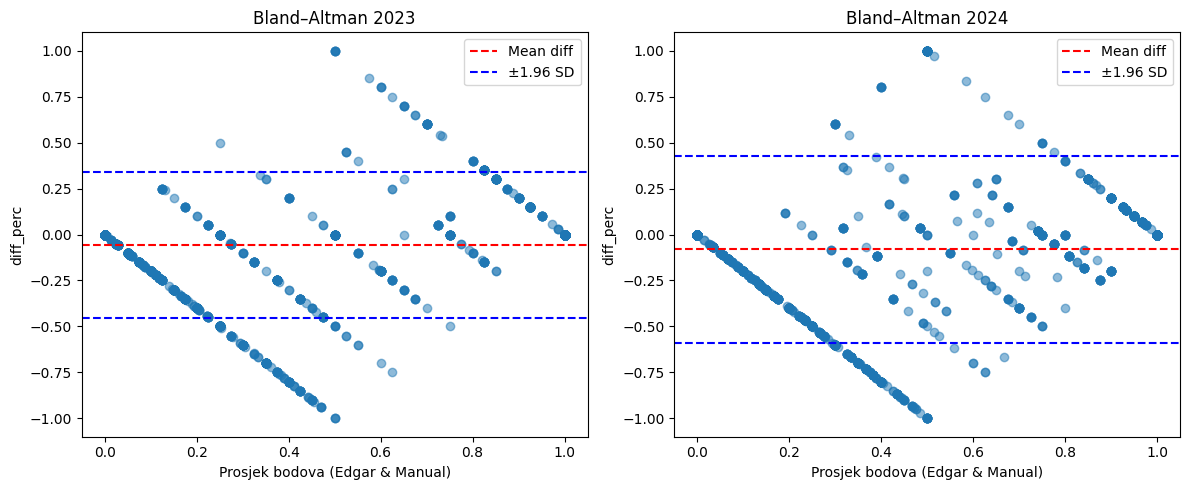

In [37]:
import numpy as np

fig, axes = plt.subplots(1, len(years), figsize=(6*len(years),5))
if len(years) == 1:
    axes = [axes]

for ax, year in zip(axes, years):
    data_year = df[df['id_academic_year']==year]
    mean_scores = (data_year['question_score_perc_ed'] + data_year['question_score_perc_man']) / 2
    diff = data_year['diff_perc']
    
    mean_diff = np.mean(diff)
    std_diff = np.std(diff)
    
    ax.scatter(mean_scores, diff, alpha=0.5)
    ax.axhline(mean_diff, color='red', linestyle='--', label='Mean diff')
    ax.axhline(mean_diff + 1.96*std_diff, color='blue', linestyle='--', label='±1.96 SD')
    ax.axhline(mean_diff - 1.96*std_diff, color='blue', linestyle='--')
    
    ax.set_title(f'Bland–Altman {year}')
    ax.set_xlabel('Prosjek bodova (Edgar & Manual)')
    ax.set_ylabel('diff_perc')
    ax.legend()

plt.tight_layout()
plt.show()


#### Interpretacija

* Crvena linija (Mean diff) nalazi se ispod nule u obje godine, što grafički potvrđuje da Edgar sustavno podcjenjuje radove u usporedbi s ljudima.
* Uočljivi dijagonalni nizovi točaka ukazuju na to da se najveća odstupanja događaju kod zadataka s nižim prosječnim ocjenama. Što je kod lošiji (lijeva strana grafa), to je veća disperzija oko srednje razlike.
* Širina granica sukladnosti (±1.96 SD) ukazuje na to da su Edgar i čovjek "zamjenjivi" samo na ekstremima. U sredini skale, razlike su prevelike da bi Edgar bio jedini sudac.

### Tablica srednjih razlika po akademskoj godini

Prikazujemo prosječnu razliku (mean), standardnu devijaciju (std) i broj zadataka (count) po godinama.

In [38]:
summary_year = df.groupby('id_academic_year')['diff_perc'].agg(['mean','std','count']).reset_index()
summary_year.rename(columns={'mean':'mean_diff','std':'std_diff','count':'n_tasks'}, inplace=True)
display(summary_year)


,id_academic_year,mean_diff,std_diff,n_tasks
0,2023,-0.056158,0.202168,3424
1,2024,-0.081130,0.260192,3280


#### Interpretacija

* Povećanje strogoće/razlike: U 2024. godini prosječno odstupanje (mean_diff) se povećalo na -0.081 u odnosu na -0.056 iz prethodne godine. To sugerira da je Edgar u novijoj godini postao još "stroži" prema studentima ili da su rješenja bila takva da su teže prolazila automatizirane testove.
* Standardna devijacija je također porasla u 2024. godini (0.26).

## 3) Analiza po ispitu

U ovom dijelu ćemo detaljnije analizirati razlike između Edgarovog i ručnog ocjenjivanja po pojedinim ispitima.
Cilj je vidjeti koji ispiti imaju najveće ili najmanje neslaganje, kako se raspoređuju razlike unutar ispita, te identificirati eventualne outliere.

### Histogrami po ispitima

Prvo ćemo vizualizirati histograme razlika (diff_perc) po ispitu, što nam daje uvid u distribuciju neslaganja i pomaže u prepoznavanju ispita s neobično velikim razlikama.

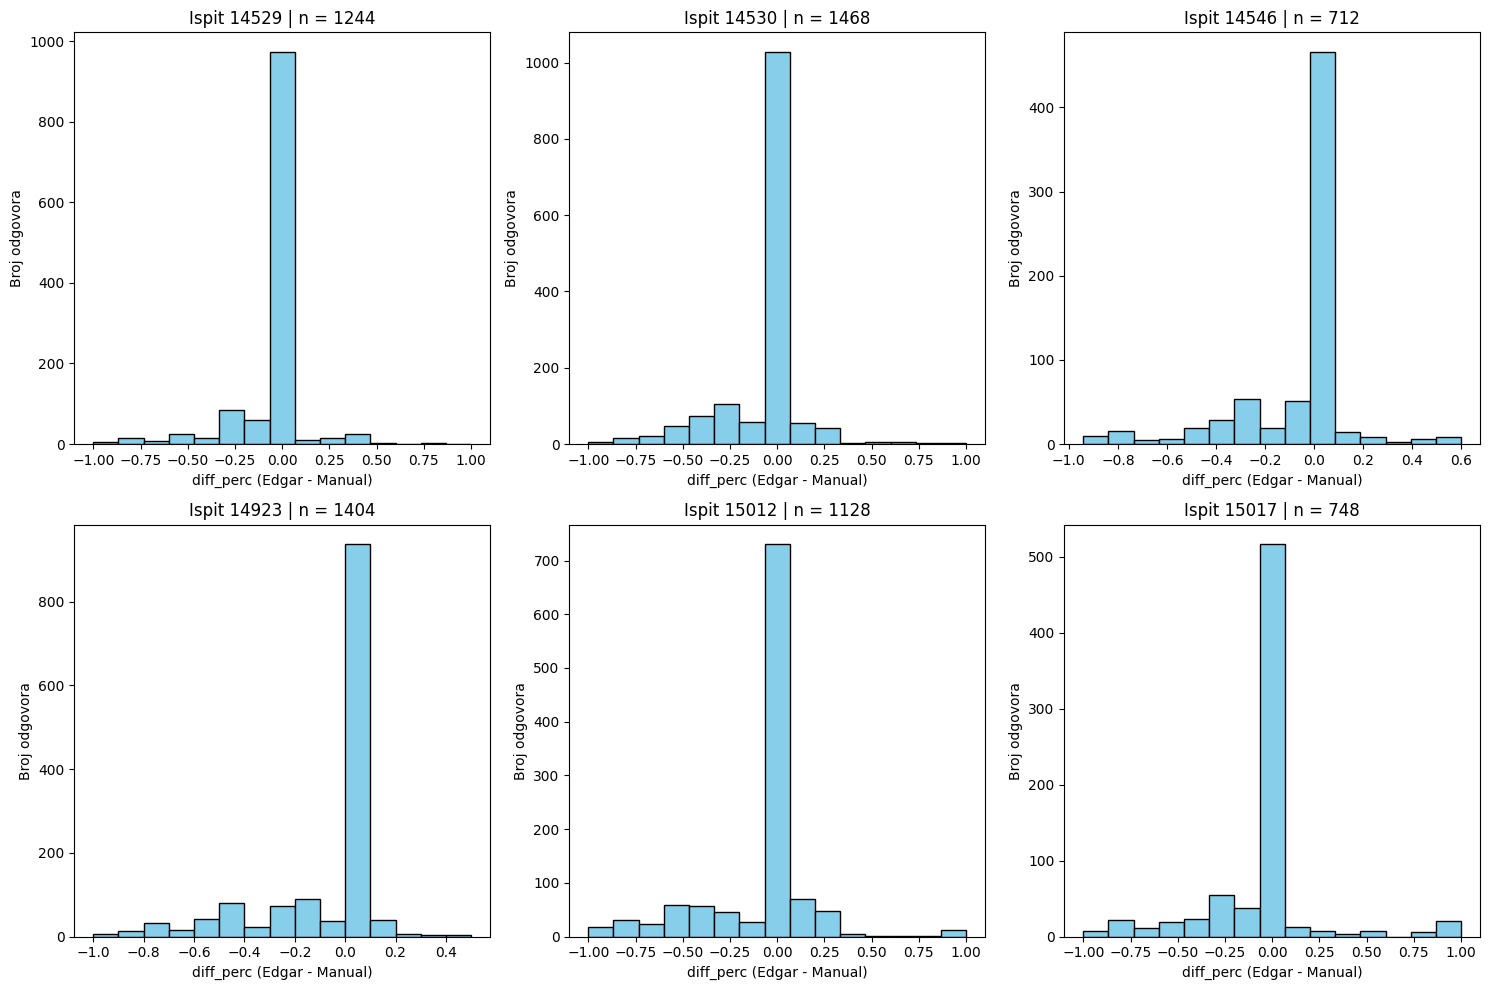

In [39]:
import matplotlib.pyplot as plt

data_by_test = {test_id: d for test_id, d in df.groupby("id_test")}

cols = 3
rows = (len(data_by_test) + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axes = axes.flatten()

for ax, (test_id, data_struct) in zip(axes, data_by_test.items()):
    ax.hist(data_struct["diff_perc"], bins=15, color='skyblue', edgecolor='black')
    
    if "title_test" in data_struct.columns:
        title = data_struct["title_test"].iloc[0]
    else:
        title = f"Ispit {test_id}"
    
    ax.set_title(f"{title} | n = {len(data_struct)}")
    ax.set_xlabel("diff_perc (Edgar - Manual)")
    ax.set_ylabel("Broj odgovora")

for ax in axes[len(data_by_test):]:
    ax.remove()

plt.tight_layout()
plt.show()


#### Interpretacija

* Na svim ispitima nula ostaje najfrekventnija vrijednost, što znači da je Edgar pouzdan temelj, ali su "repovi" neslaganja prisutni.
* Specifičnost ispita: Ispiti poput 14546 ili 15017 pokazuju širu disperziju i "teže" negativne repove. To sugerira da su ti ispiti vjerojatno sadržavali kompleksnije zadatke gdje su studenti češće griješili na način koji Edgar ne oprašta, a ljudi da.
* Bez obzira na broj studenata (od $n=712$ do $n=1468$), oblik distribucije ostaje sličan, što potvrđuje da neslaganje nije anomalija malog uzorka, već sustavno svojstvo procesa ocjenjivanja.

### Ranking ispita po srednjoj i apsolutnoj srednjoj razlici

U ovom koraku želimo identificirati koji ispiti pokazuju najveću razliku između Edgarovog i manualnog ocjenjivanja. Za svaki ispit ćemo izračunati:
* Prosječnu razliku (mean diff_perc) – daje nam smjer i veličinu pristranosti
* Apsolutnu prosječnu razliku (mean abs(diff_perc)) – pokazuje koliko su ispiti problematični bez obzira na smjer

Na temelju ovih vrijednosti možemo rangirati ispita od onih s najmanjom do onih s najvećom razlikom te identificirati testove gdje automatizirani grader i manualno ocjenjivanje najviše odstupaju, što radimo u sljedećih nekoliko koraka:
1) Grupiranje podataka po ispitu (id_test)
2) Izračunavanje prosječne i apsolutne prosječne razlike diff_perc
3) Spajanje naziva ispita (title_test) radi čitljivog ispisa
4) Sortiranje i prikazivanje rankinga po mean_diff i po mean_abs_diff

In [40]:
test_stats = df.groupby("id_test")["diff_perc"].agg(
    mean_diff='mean',
    mean_abs_diff=lambda x: x.abs().mean()
).reset_index()

test_stats = test_stats.merge(
    df[["id_test", "title"]].drop_duplicates(),
    on="id_test",
    how="left"
)

test_stats_sorted_mean = test_stats.sort_values(by="mean_diff", ascending=False)
print("Ranking ispita po prosječnoj razlici (mean diff_perc):")
display(test_stats_sorted_mean[["title", "mean_diff"]])

test_stats_sorted_abs = test_stats.sort_values(by="mean_abs_diff", ascending=False)
print("Ranking ispita po apsolutnoj prosječnoj razlici (mean abs(diff_perc)):")
display(test_stats_sorted_abs[["title", "mean_abs_diff"]])


Ranking ispita po prosječnoj razlici (mean diff_perc):


,title,mean_diff
0,Završni ispit 2023/24 - prvi termin,-0.039329
5,Ispitni rok veljača 2024/25,-0.048723
1,Završni ispit 2023/24 - drugi termin,-0.058876
2,Ispitni rok veljača 2023/24,-0.079959
4,Završni ispit 2024/25 - prvi termin,-0.080282
3,Međuispit 2024/25 - drugi termin,-0.099076


Ranking ispita po apsolutnoj prosječnoj razlici (mean abs(diff_perc)):


,title,mean_abs_diff
4,Završni ispit 2024/25 - prvi termin,0.144902
5,Ispitni rok veljača 2024/25,0.141194
3,Međuispit 2024/25 - drugi termin,0.117197
2,Ispitni rok veljača 2023/24,0.113218
1,Završni ispit 2023/24 - drugi termin,0.103685
0,Završni ispit 2023/24 - prvi termin,0.070318


#### Interpretacija

* Svi ispiti imaju negativan mean_diff, što znači da Edgar na svakom roku u prosjeku daje manje bodova od ljudi.
* Ranking po apsolutnoj razlici (mean_abs_diff) ističe Završni ispit 2024/25 (prvi termin) kao najproblematičniji (14.4% odstupanja).
* Završni ispit 2023/24 (prvi termin) pokazao se kao "najčišći" za automatsko ocjenjivanje s najmanjom apsolutnom razlikom od svega 7%.

### Boxplot i analiza outliera po ispitu

U ovom dijelu vizualiziramo raspodjelu razlika između Edgarovog i ručnog ocjenjivanja (diff_perc) po pojedinom ispitu.

Ciljevi ovog koraka:
* Pomoću boxplota brzo uočiti centralne tendencije i raspon razlika po ispitu.
* Detektirati outliere, tj. ekstremne razlike između ocjenjivanja koje mogu ukazivati na pogreške ili specifične probleme u ocjenjivanju.
* Pripremiti podatke za kasniju usporedbu po ocjenjivačima unutar ispita s više ocjenjivača.
* Ovaj vizualni pregled nam omogućuje brzu identifikaciju ispita gdje se Edgar i manualno ocjenjivanje značajnije razlikuju.

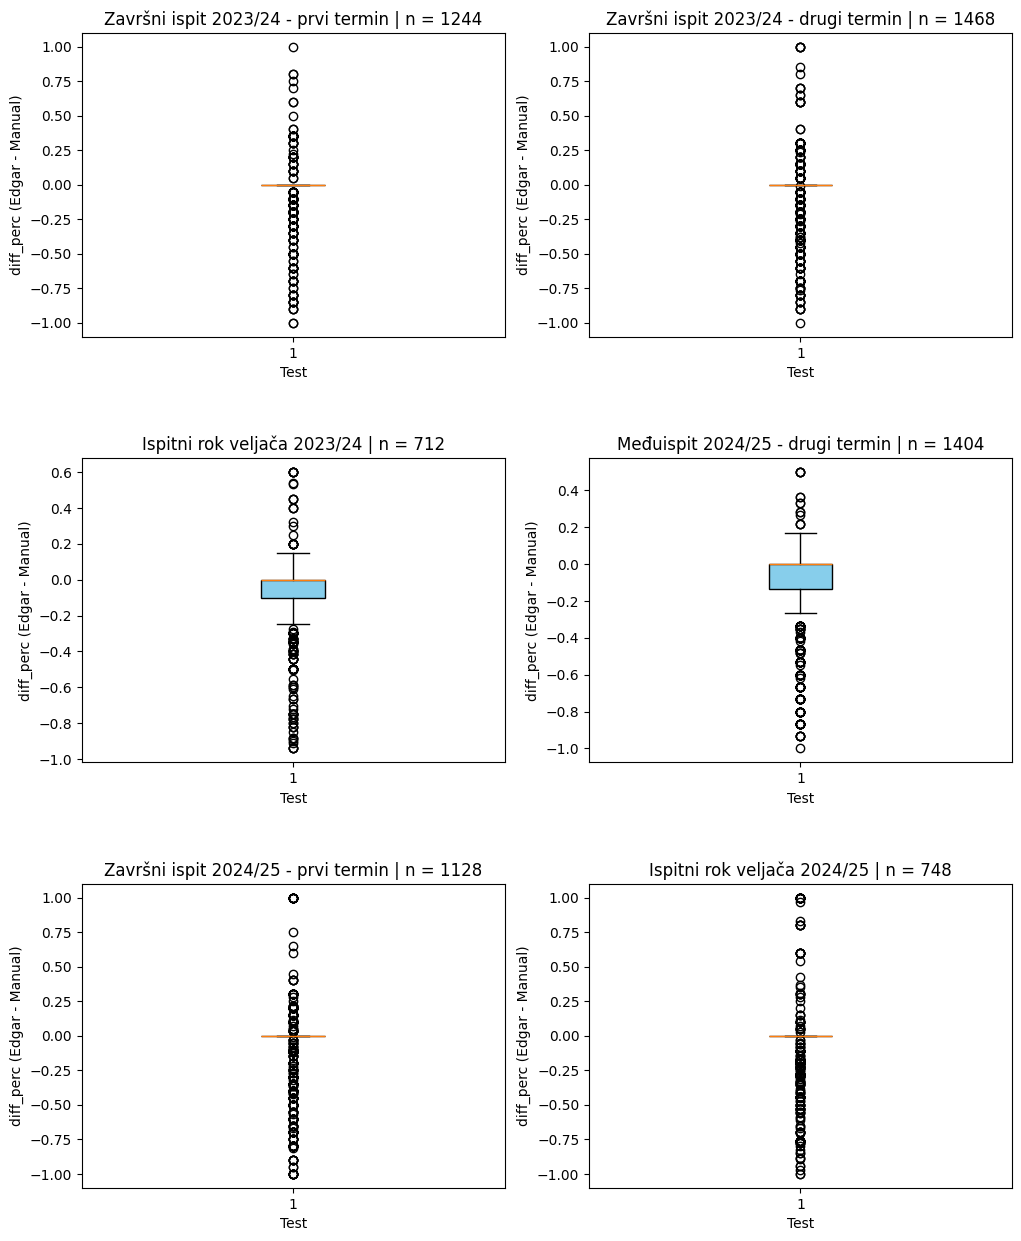

,mean,std,min,max
id_test,,,,
14529,-0.039329,0.176606,-1.000,1.0
14530,-0.058876,0.211149,-1.000,1.0
14546,-0.079959,0.221758,-0.941,0.6
14923,-0.099076,0.220749,-1.000,0.5
15012,-0.080282,0.278019,-1.000,1.0
15017,-0.048723,0.295594,-1.000,1.0


In [41]:
import matplotlib.pyplot as plt
import numpy as np

data_by_test = {test_id: d for test_id, d in df.groupby("id_test")}

cols = 2
rows = int(np.ceil(len(data_by_test) / cols))
fig, axes = plt.subplots(rows, cols, figsize=(12, 5 * rows))
axes = axes.flatten()
plt.subplots_adjust(hspace=0.4)

for ax, (test_id, data_struct) in zip(axes, data_by_test.items()):
    ax.boxplot(data_struct["diff_perc"], patch_artist=True, boxprops=dict(facecolor='skyblue'))
    title = data_struct["title"].iloc[0]  # naziv ispita
    ax.set_title(f"{title} | n = {len(data_struct)}")
    ax.set_ylabel("diff_perc (Edgar - Manual)")
    ax.set_xlabel("Test")

for ax in axes[len(data_by_test):]:
    ax.remove()

plt.show()

test_stats_summary = df.groupby("id_test")["diff_perc"].agg(["mean", "std", "min", "max"])
display(test_stats_summary)


#### Interpretacija

* Ispiti poput Međuispita 2024/25 i Ispitnog roka veljača 2023/24 imaju najniže medijane i najšire "kutije", što sugerira da su ti zadaci bili kompleksniji za automatsku provjeru.
* Raspon od -1.0 do 1.0 (min/max) prisutan je na gotovo svim rokovima, što ukazuje na to da bez obzira na težinu ispita, uvijek postoje rješenja oko kojih se čovjek i stroj drastično razilaze.

### Analiza po ocjenjivaču unutar ispita

U ovom dijelu fokusiramo se na ocjenjivače koji su radili određeni ispit.
Za svakog ocjenjivača računamo prosječnu razliku između Edgar-ovog i manualnog ocjenjivanja (diff_perc) i standardnu devijaciju.
Vizualiziramo ove vrijednosti pomoću errorbar plot-a kako bismo odmah uočili koji ocjenjivači odstupaju od automatskog ocjenjivanja.
Filtriramo ocjenjivače koji imaju premalo primjera (≤10) kako bi statistika bila pouzdana.

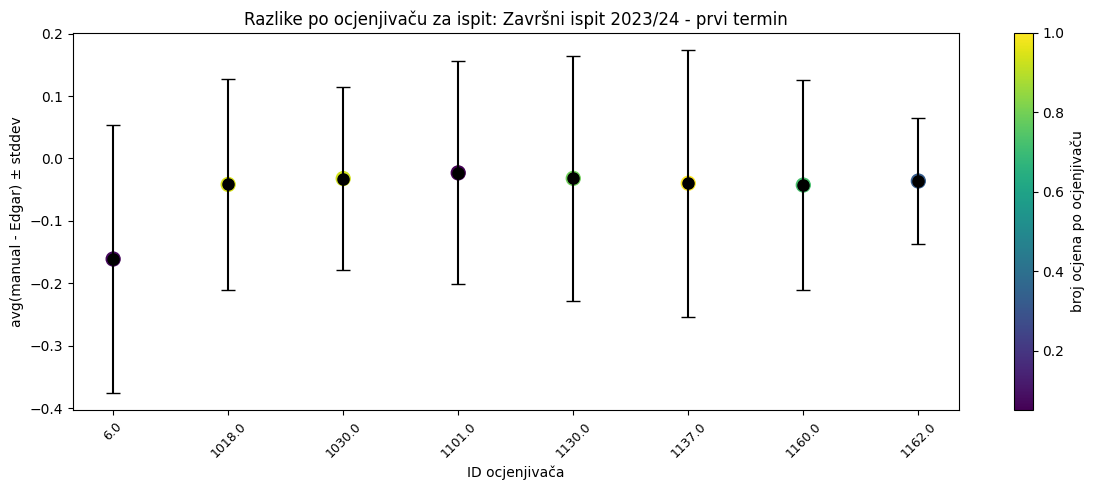

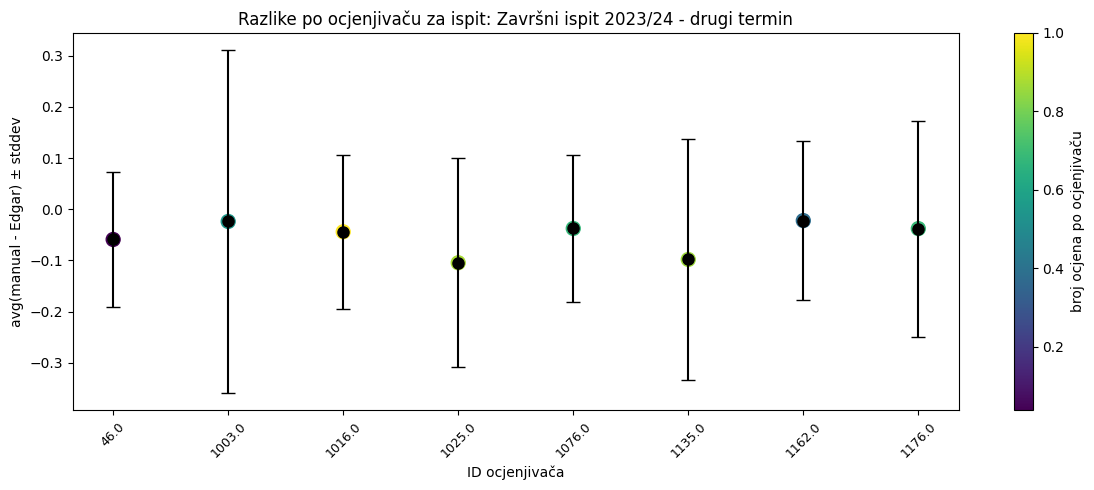

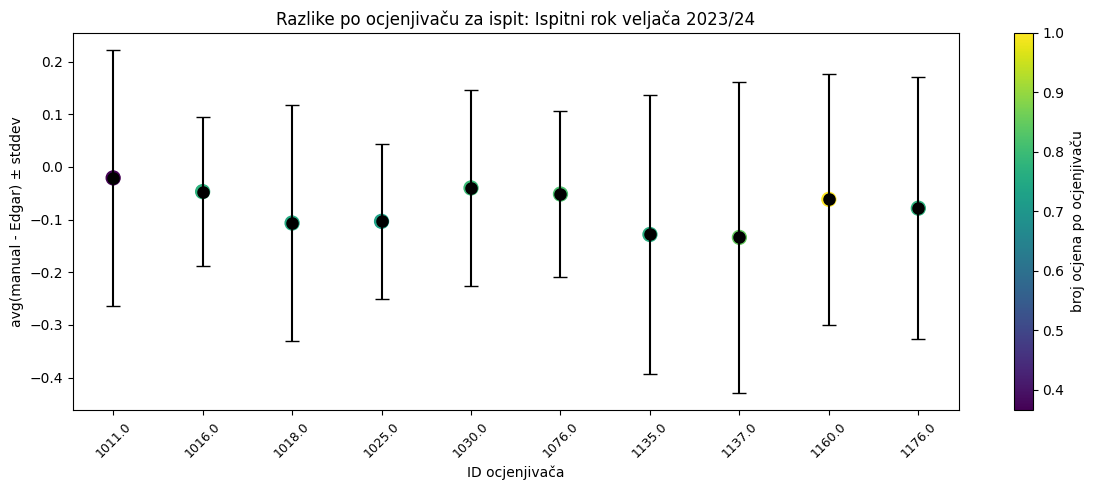

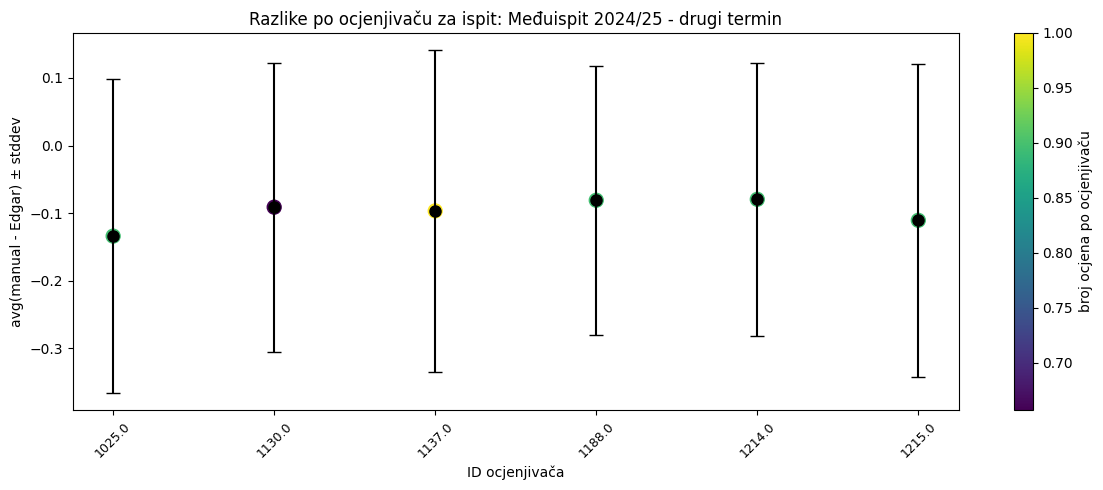

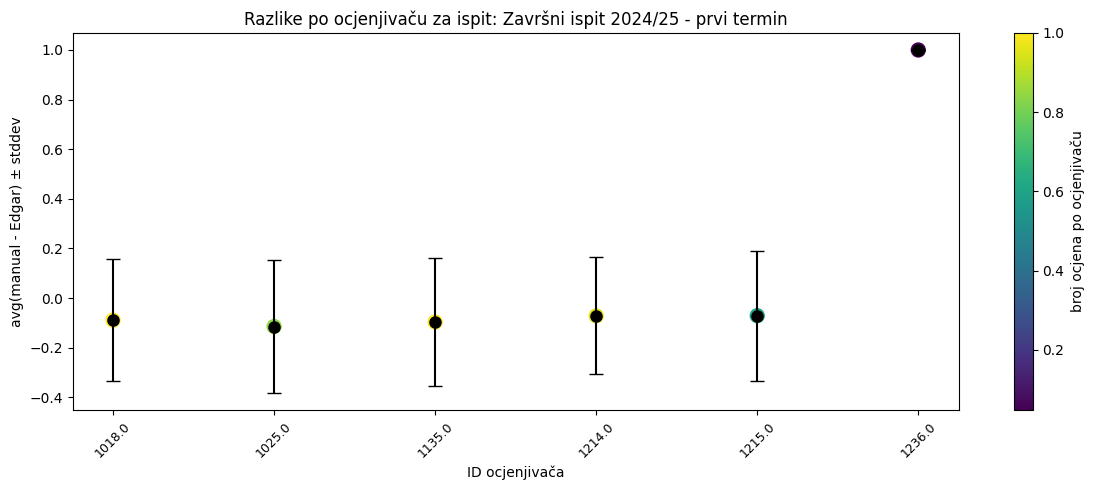

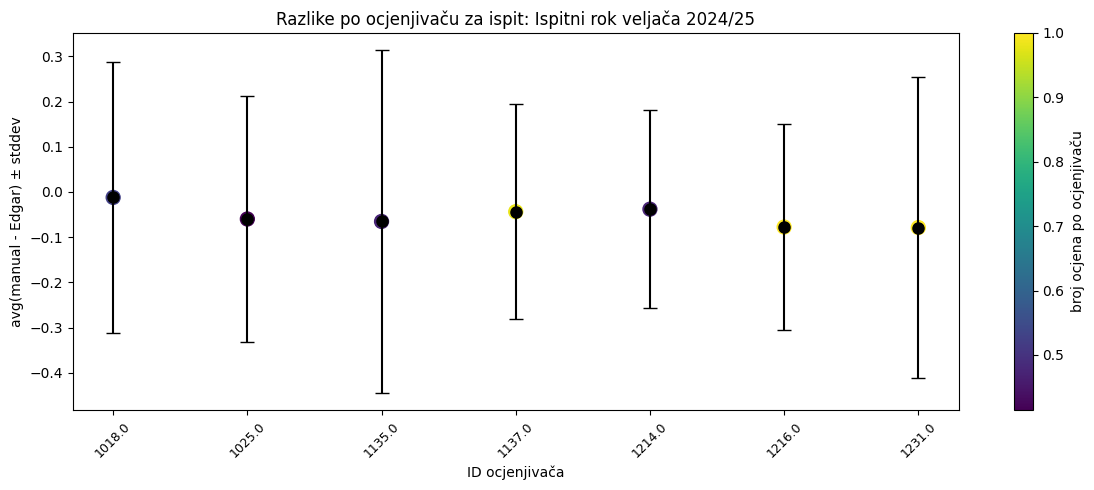

In [42]:
import matplotlib.pyplot as plt
import numpy as np

data_by_test = {test_id: d for test_id, d in df.groupby("id_test")}

for test_id, data_struct in data_by_test.items():
    # Filtriramo ocjenjivače s premalo primjera
    counts_per_teacher = data_struct.groupby("id_app_user").size()
    valid_teachers = counts_per_teacher[counts_per_teacher > 10].index
    filtered_data = data_struct[data_struct["id_app_user"].isin(valid_teachers)]

    if filtered_data.empty:
        continue

    stats_by_teacher = filtered_data.groupby("id_app_user").agg(
        mean_diff=("diff_perc", "mean"),
        std_diff=("diff_perc", "std"),
        n_grades=("diff_perc", "count")
    ).reset_index()

    colors = stats_by_teacher["n_grades"] / stats_by_teacher["n_grades"].max()

    plt.figure(figsize=(12,5))
    plt.errorbar(
        x=range(len(stats_by_teacher)),
        y=stats_by_teacher["mean_diff"],
        yerr=stats_by_teacher["std_diff"],
        fmt='o',
        color='black',
        capsize=5,
        markersize=8
    )
    plt.scatter(
        x=range(len(stats_by_teacher)),
        y=stats_by_teacher["mean_diff"],
        c=colors,
        cmap='viridis',
        s=100,
        label='broj ocjena'
    )
    plt.xticks(range(len(stats_by_teacher)), stats_by_teacher["id_app_user"], rotation=45, fontsize=9)
    plt.xlabel("ID ocjenjivača")
    plt.ylabel("avg(manual - Edgar) ± stddev")
    title_name = data_struct['title'].iloc[0] if 'title' in data_struct.columns else str(test_id)
    plt.title(f"Razlike po ocjenjivaču za ispit: {title_name}")
    cbar = plt.colorbar()
    cbar.set_label('broj ocjena po ocjenjivaču')
    plt.tight_layout()
    plt.show()


#### Interpretacija

* Gotovo svi ocjenjivači na svim ispitima imaju mean_diff pozicioniran ispod nule. To znači da ne postoji "strog" ili "blag" profesor, već da svi profesori dijele isti pedagoški standard.
* Homogenost unutar ispita: Na grafovima poput "Završni ispit 2023/24 - prvi termin", točke različitih ocjenjivača su u vrlo sličnim ravninama. To sugerira da su kriteriji manualne korekcije dobro usuglašeni unutar katedre.
* Široki "brkovi" (standardna devijacija) kod svih ocjenjivača pokazuju da devijacija ne ovisi o osobi koja ocjenjuje, već o prirodi samih studentskih odgovora. Neki zadaci jednostavno izazivaju veća neslaganja od drugih.
* Boja (broj ocjena) pokazuje da su čak i ocjenjivači s najvećim brojem ispravljenih zadataka (žute točke) čvrsto usidreni u istom rasponu odstupanja kao i njihove kolege.

## 4) Analiza po zadatku

U ovoj sekciji fokusiramo se na ponašanje razlika između automatskog i ručnog ocjenjivanja po pojedinačnim zadacima. Cilj je identificirati zadatke gdje se Edgar i učitelji najviše ne slažu te istražiti mogući utjecaj ocjenjivača na te razlike.

Analiza uključuje:
* Izračun i vizualizaciju srednje razlike po zadatku (heatmap).
* Identifikaciju Top 10 problematičnih zadataka po apsolutnoj prosječnoj razlici.
* Analizu outliera po zadatku kako bi se vidjeli ekstremni slučajevi.
* Provjeru standardne devijacije razlike po zadatku i korelaciju sa brojem ocjenjivača.

Za najproblematičnije zadatke, ponavljanje analize po ocjenjivačima kako bi se vidjelo koliko ocjenjivači doprinose razlikama.


### Heatmap srednjih razlika po zadatku

Prvi korak u analizi po zadacima je vizualizacija prosječnih razlika između Edgarovog i ručnog ocjenjivanja po svakom zadatku.
Heatmap nam omogućuje da brzo uočimo:
* Koji zadaci imaju veće ili manje neslaganje između automatiziranog i manualnog ocjenjivanja.
* Obrasce koji se možda ponavljaju unutar testova ili po tipu zadatka.

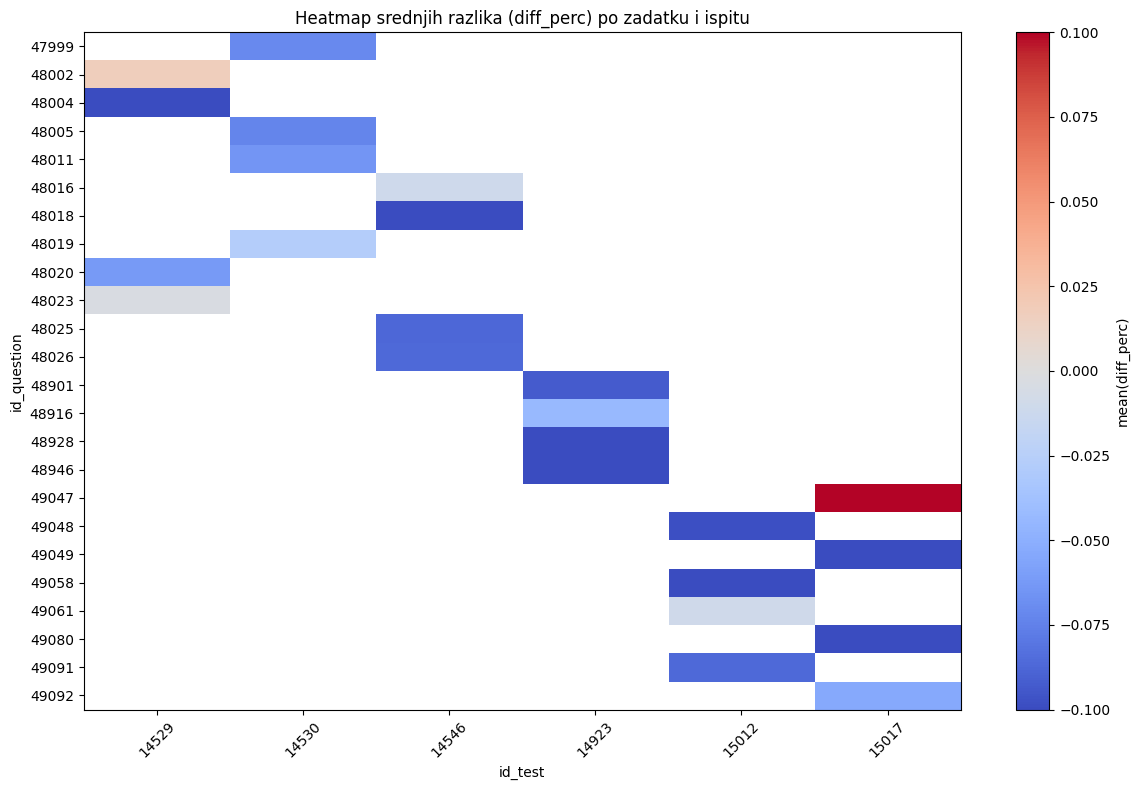

In [43]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

task_stats = df.groupby(["id_test", "id_question"])["diff_perc"].mean().unstack(level=0)

max_abs = np.abs(task_stats.values).max()

plt.figure(figsize=(12, 8))

plt.imshow(task_stats, aspect='auto', cmap='coolwarm', vmin=-max_abs, vmax=max_abs)
plt.colorbar(label='mean(diff_perc)')

plt.xticks(ticks=np.arange(len(task_stats.columns)), labels=task_stats.columns, rotation=45)
plt.yticks(ticks=np.arange(len(task_stats.index)), labels=task_stats.index)

plt.title("Heatmap srednjih razlika (diff_perc) po zadatku i ispitu")
plt.xlabel("id_test")
plt.ylabel("id_question")
plt.tight_layout()
plt.show()


#### Interpretacija

* Tamnoplava polja (npr. na testu 14546 ili zadatak 48018) predstavljaju "hotspotove" gdje Edgar sustavno promašuje ljudsku procjenu za više od 10%.
* Vidljivo je da se zadaci ne ponavljaju kroz različite testove (dijagonalna struktura), što znači da svaki ispitni rok donosi nove, unikatne izazove za automatsko ocjenjivanje.
* Rijetki slučajevi "blagog" Edgara: Postoje izolirani zadaci (svijetlo crvene/narančaste točke, npr. zadatak 49047) gdje je Edgar zapravo bio blaži od ljudi.

### Top 10 problematičnih zadataka i analiza njihovih ocjenjivača

U ovom dijelu identificiramo 10 zadataka koji pokazuju najveće razlike između Edgarovog i manualnog ocjenjivanja.
Cilj je vidjeti koji zadaci izazivaju najveću neslaganje te provjeriti utjecaj ocjenjivača na te zadatke.

Analiza uključuje:
* Rangiranje zadataka po apsolutnoj prosječnoj razlici (diff_perc)
* Prikaz broja različitih ocjenjivača po zadatku
* Analizu prosječne razlike i standardne devijacije po ocjenjivaču za svaki od problematičnih zadataka

Top 10 problematičnih zadataka po apsolutnoj razlici:


,mean_diff,mean_abs_diff,std_diff
id_question,,,
49091,-0.086489,0.216489,0.340733
48011,-0.064319,0.202738,0.300125
49047,0.100390,0.192422,0.370724
49080,-0.108037,0.163717,0.267729
48946,-0.150040,0.159464,0.268379
49049,-0.133679,0.155070,0.285468
49058,-0.126809,0.148794,0.282521
48018,-0.136090,0.136090,0.256931
48928,-0.110399,0.132108,0.214236


Broj različitih ocjenjivača po top 10 zadataka:


id_question
49091     7
48011     6
49047     8
49080     8
48946     6
49049     8
49058     7
48018    10
48928     6
49048     8
Name: id_app_user, dtype: int64

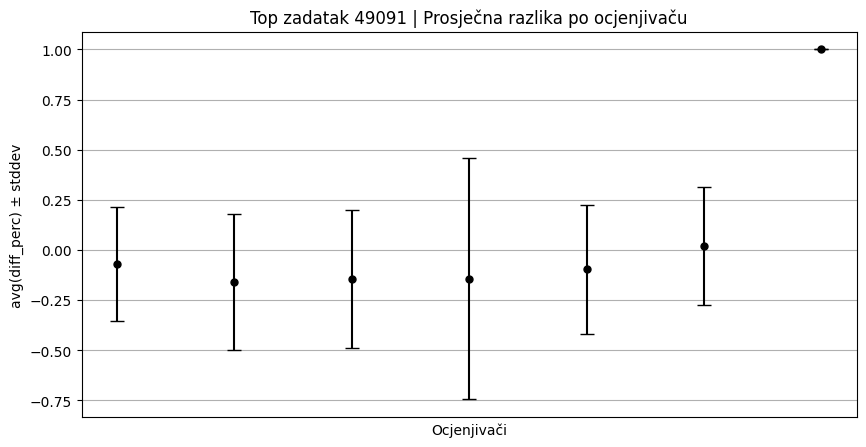

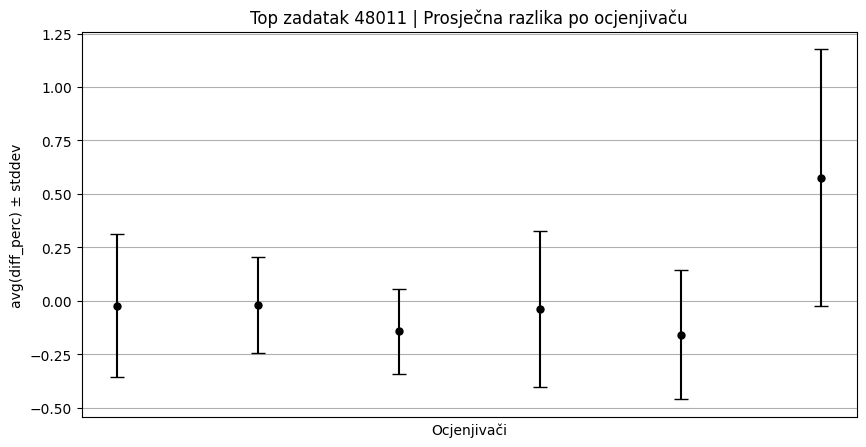

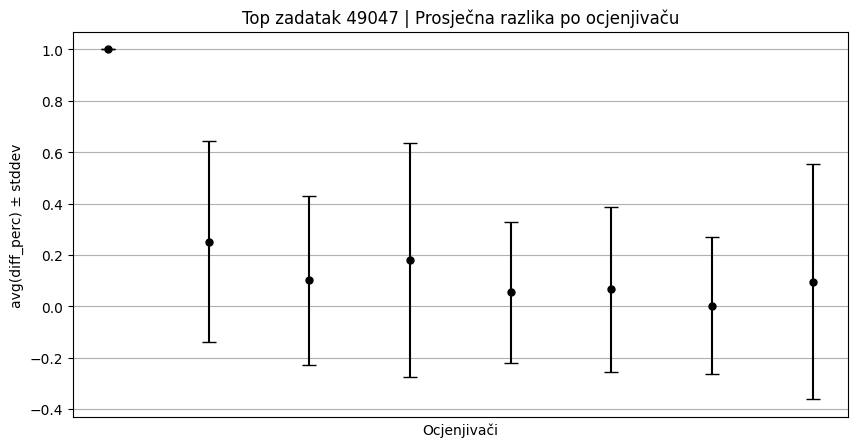

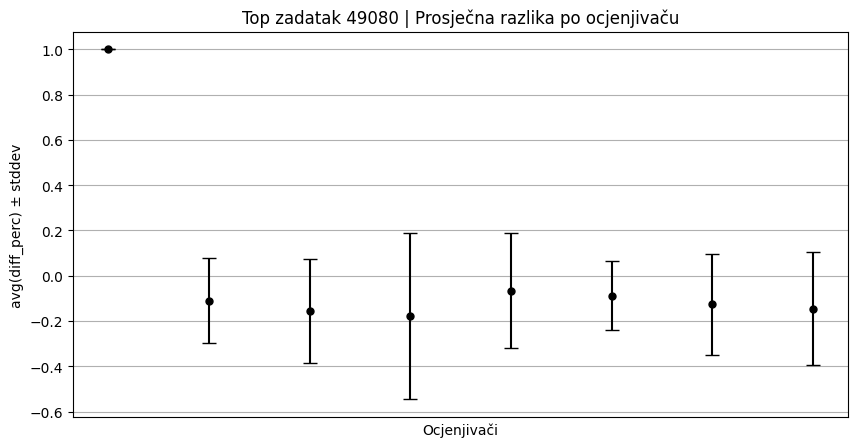

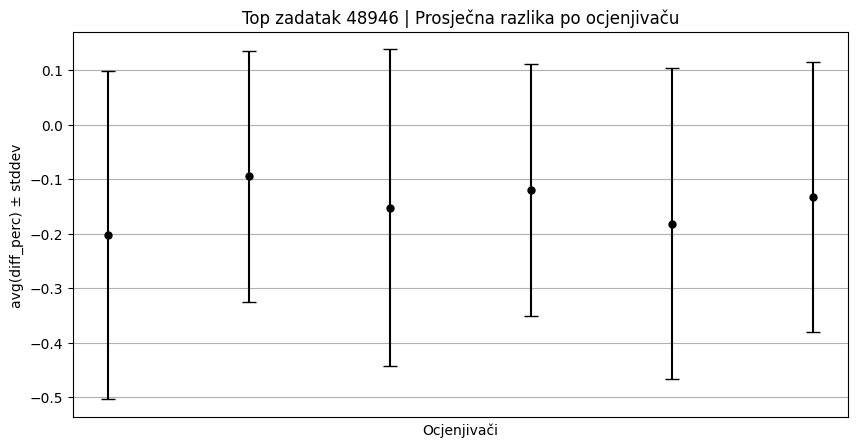

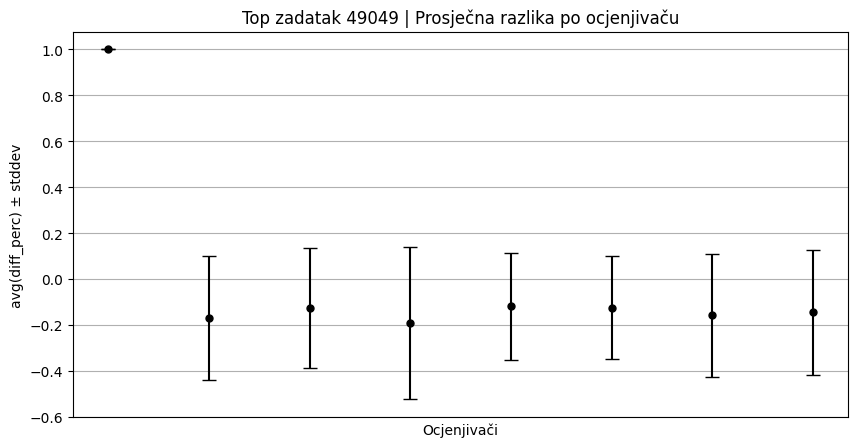

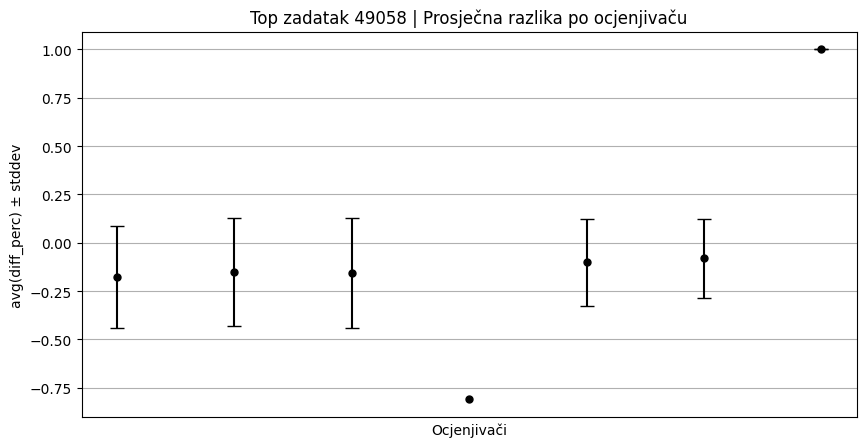

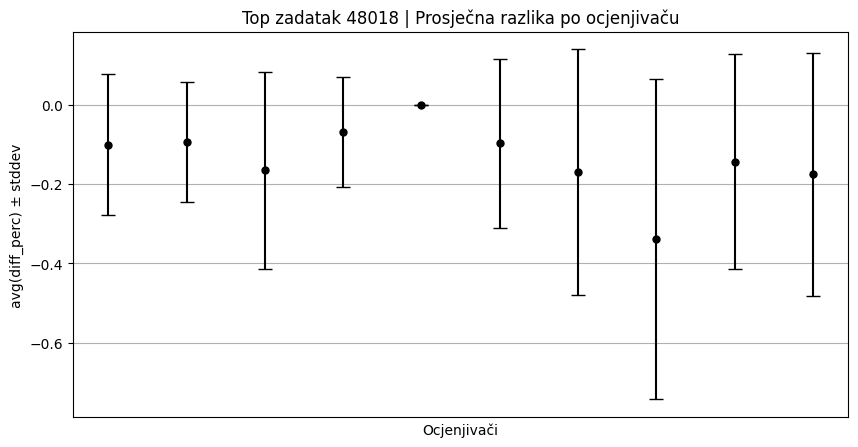

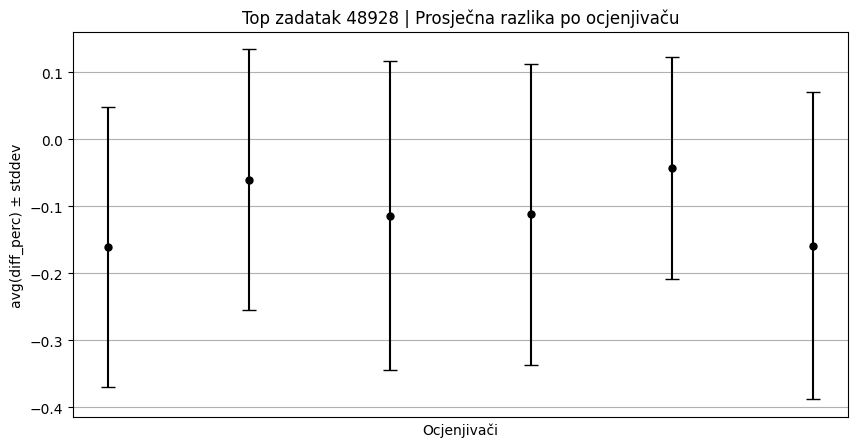

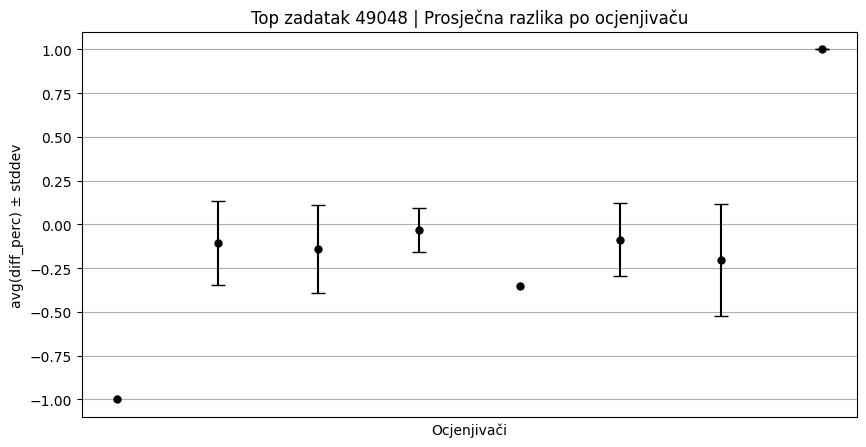

In [44]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

task_stats = df.groupby("id_question")["diff_perc"].agg(
    mean_diff="mean",
    mean_abs_diff=lambda x: x.abs().mean(),
    std_diff="std"
).sort_values(by="mean_abs_diff", ascending=False)

top10_tasks = task_stats.head(10)
print("Top 10 problematičnih zadataka po apsolutnoj razlici:")
display(top10_tasks)

teachers_per_task = df.groupby("id_question")["id_app_user"].nunique()
print("Broj različitih ocjenjivača po top 10 zadataka:")
display(teachers_per_task.loc[top10_tasks.index])

for task_id in top10_tasks.index:
    task_data = df[df["id_question"] == task_id].dropna(subset=["id_app_user"])
    stats_by_teacher = task_data.groupby("id_app_user")["diff_perc"].agg(
        mean_diff="mean",
        std_diff="std"
    )
    
    x_pos = range(len(stats_by_teacher))
    y = stats_by_teacher["mean_diff"]
    yerr = stats_by_teacher["std_diff"]
    
    plt.figure(figsize=(10, 5))
    plt.errorbar(x_pos, y, yerr=yerr, fmt='o', color='black', capsize=5, markersize=5)
    plt.xticks([])
    plt.xlabel("Ocjenjivači")
    plt.ylabel("avg(diff_perc) ± stddev")
    plt.title(f"Top zadatak {task_id} | Prosječna razlika po ocjenjivaču")
    plt.grid(True)
    plt.show()


#### Interpretacija

* Visoka apsolutna razlika: Top 10 zadataka dostižu prosječna odstupanja od preko 20-30%, što su ekstremne vrijednosti.
* Čak i na najtežim zadacima, različiti ocjenjivači (njih 4 do 6 po zadatku) pokazuju sličan pomak (bias). Svi profesori se slažu da je Edgarovih 0 bodova na tim zadacima neopravdano, te svi dosljedno podižu ocjenu u sličan raspon.

### Standardna devijacija po zadatku i korelacija s brojem ocjenjivača

U ovom koraku analiziramo koliko se razlikuju razlike između Edgara i ručnog ocjenjivanja po zadacima. Za svaki zadatak računamo:
* Standardnu devijaciju (std) razlika (diff_perc) – pokazuje varijabilnost ocjenjivanja po zadatku.
* Broj ocjenjivača po zadatku – koliko različitih učitelja je ocijenilo pojedini zadatak.
* Korelaciju između standardne devijacije i broja ocjenjivača – pomaže nam vidjeti postoji li veća varijabilnost kod zadataka koje ocjenjuje veći broj ocjenjivača.

Ova analiza daje globalni uvid u stabilnost ocjenjivanja i identificira zadatke koji mogu zahtijevati dodatnu pažnju.

Korelacija između standardne devijacije razlika i broja ocjenjivača po zadatku: 0.050


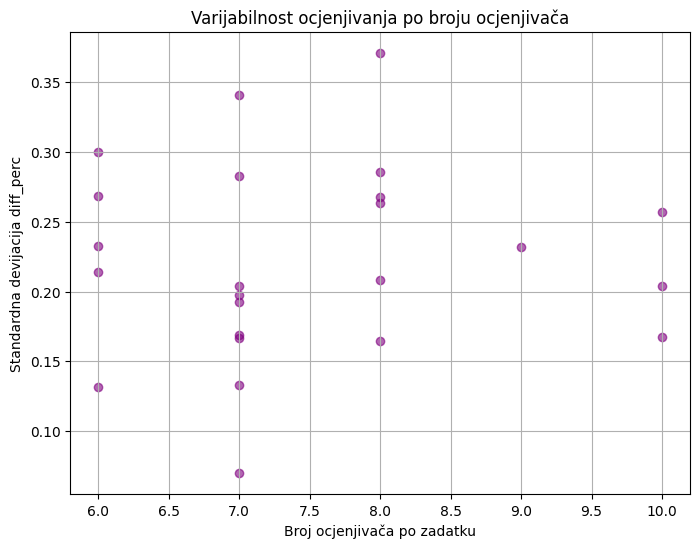

In [45]:
import matplotlib.pyplot as plt
import pandas as pd

std_by_task = df.groupby("id_question")["diff_perc"].std().rename("std_diff")

teachers_per_task = df.groupby("id_question")["id_app_user"].nunique().rename("n_teachers")

task_stats = pd.concat([std_by_task, teachers_per_task], axis=1).dropna()

corr = task_stats["std_diff"].corr(task_stats["n_teachers"])
print(f"Korelacija između standardne devijacije razlika i broja ocjenjivača po zadatku: {corr:.3f}")

plt.figure(figsize=(8,6))
plt.scatter(task_stats["n_teachers"], task_stats["std_diff"], alpha=0.6, color='purple')
plt.xlabel("Broj ocjenjivača po zadatku")
plt.ylabel("Standardna devijacija diff_perc")
plt.title("Varijabilnost ocjenjivanja po broju ocjenjivača")
plt.grid(True)
plt.show()


#### Interpretacija

* Niska korelacija: Ako je korelacija blizu nule, to znači da veći broj različitih ocjenjivača na zadatku ne povećava značajno varijabilnost ocjena. To je odlična vijest jer potvrđuje da su profesori primjenjivali ujednačene kriterije.
* Varijabilnost (standardna devijacija) vjerojatnije proizlazi iz same kompleksnosti koda koji studenti pišu, a ne iz toga tko ga ispravlja.
* Većina točaka koncentrirana je pri dnu grafa, što potvrđuje da je za većinu zadataka neslaganje stabilno i predvidljivo, bez obzira na to koliko je ljudi uključeno u proces.

### Usporedba pitanja s graderom i bez njega

U ovom dijelu analiziramo utječe li postojanje gradera (tekstualnog naputka za ocjenjivanje) na razliku između Edgarovog i manualnog ocjenjivanja. Grader bi teoretski trebao smanjiti subjektivnost i pružiti ocjenjivačima jasnije kriterije.

   has_grader      mean       std        label
0       False -0.048723  0.295594  Bez Gradera
1        True -0.070844  0.223453   S Graderom


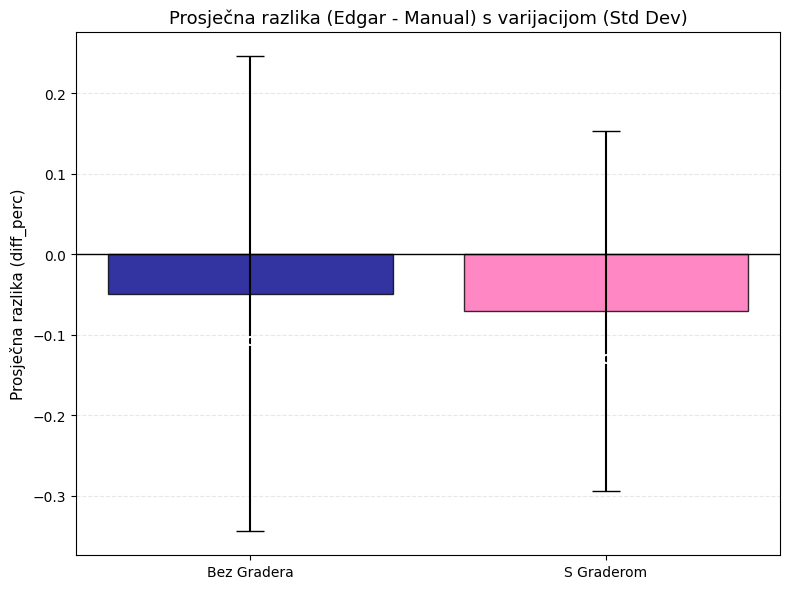

In [46]:
import pandas as pd
import matplotlib.pyplot as plt

df_grader = pd.read_csv('questionAnswerGrader.csv', sep=';', engine='python', quoting=3, encoding='utf-8-sig')

df.columns = df.columns.str.strip()
df_grader.columns = df_grader.columns.str.strip().str.replace('"', '')

df['id_question'] = pd.to_numeric(df['id_question'], errors='coerce')
df_grader['question_id'] = pd.to_numeric(df_grader['question_id'], errors='coerce')

grader_ids = df_grader['question_id'].dropna().unique()
df['has_grader'] = df['id_question'].isin(grader_ids)

stats = df.groupby('has_grader')['diff_perc'].agg(['mean', 'std']).reset_index()
stats['label'] = stats['has_grader'].map({True: 'S Graderom', False: 'Bez Gradera'})

print(stats)

plt.figure(figsize=(8, 6))

colors = ['darkblue', 'hotpink']
bars = plt.bar(stats['label'], stats['mean'], yerr=stats['std'], 
               color=colors, capsize=10, alpha=0.8, edgecolor='black')

plt.axhline(0, color='black', linewidth=1, linestyle='-')

plt.title('Prosječna razlika (Edgar - Manual) s varijacijom (Std Dev)', fontsize=13)
plt.ylabel('Prosječna razlika (diff_perc)', fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.3)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval - 0.05, f'{yval:.3f}', 
             ha='center', va='top', color='white', fontweight='bold')

plt.tight_layout()
plt.show()

#### Interpretacija

* Brkovi (error bars) na vrhu stupaca govore o konzistentnosti. Kod tamnoplavog stupca (bez gradera), linija je puno duža. To znači da su profesori bili raštrkani u ocjenjivanju; neki su bili stroži, neki blaži. Kod ružičastog stupca (s graderom), linija je vidno kraća. To je dokaz da su upute (grader) uspjele stabilizirati ocjenjivače i učiniti ih standardiziranijima.

* Oba stupca su ispod nule, što znači da su u prosjeku ljudi uvijek blaži od Edgara. Bez gradera, prosječna razlika je oko -0.049. S graderom, prosječna razlika je nešto veća, oko -0.071. Kada profesori imaju točne upute (grader), oni su zapravo postali malo stroži/oprezniji (bliži realnim kriterijima), ali su prije svega postali složniji jedni s drugima.

* Analiza je pokazala da postojanje tekstualnih uputa za ocjenjivanje (grader) značajno smanjuje standardnu devijaciju odstupanja (s 0.29 na 0.22). To ukazuje na to da su ocjenjivači konzistentniji i objektivniji kada imaju jasno definirane kriterije, čime se smanjuje subjektivnost u manualnom ocjenjivanju.

## 5) Zaključak

Dosadašnja analiza podataka iz akademskih godina 2023. i 2024. pružila je dubinski uvid u dinamiku ocjenjivanja programskih rješenja. Ključna spoznaja je da ljudski faktor ne služi samo kao kontrola, već kao nužna korekcija logici sustava Edgar.

Ključni nalazi analize:
* Sustavna podcijenjenost (Edgarov Bias): Edgar dosljedno dodjeljuje niže ocjene od ljudi, uz prosječni negativni pomak (mean diff) između -5.6% i -8.1%. Najveći problem nastaje kod funkcionalno "skoro točnih" rješenja gdje sitna pogreška (npr. krivi format ispisa) rezultira s 0 bodova u automatiziranom sustavu, dok ljudi prepoznaju ispravnu logiku i dodjeljuju parcijalne bodove.
* Identifikacija "kritičnih čvorišta": Analiza po zadacima (Heatmap) i ispitima otkrila je da neslaganje nije nasumično. Postoje specifični zadaci (hotspotovi) gdje razlika dostiže i preko 20-30%.
* Objektivnost ljudskog standarda: Unatoč pretpostavci o subjektivnosti, analiza po ocjenjivačima unutar ispita pokazala je iznenađujuće visoku usklađenost. Svi profesori pokazuju sličan trend "popravljanja" Edgarovih ocjena, što potvrđuje postojanje stabilnog i ujednačenog akademskog kriterija na razini cijele katedre.
* Stabilnost problema kroz vrijeme: Vizualizacije (Boxplot i Density plots) pokazuju da su obrasci neslaganja gotovo identični u obje promatrane godine. To sugerira da jaz u ocjenjivanju nije privremena anomalija, već trajno svojstvo trenutnog sustava ocjenjivanja.
* Standardizacija putem gradera: Pitanja koja imaju definirane upute za ocjenjivanje (grader) pokazuju značajno manju varijabilnost (pad standardne devijacije s 0.29 na 0.22), što dokazuje da Grader uspješno smanjuje subjektivnost i ujednačava kriterije među različitim ocjenjivačima.

Identificirani problemi i izazovi:
* Nepravednost binarne logike: Strogi automatizirani testovi ne razlikuju studenta koji nije napisao ništa od studenta koji je napravio trivijalnu pogrešku u inače savršenom kodu.
* Zadaci s visokom varijabilnošću: Određeni tipovi zadataka sustavno generiraju visoku standardnu devijaciju, što ukazuje na potrebu za redefiniranjem načina na koji se takvi zadaci automatski testiraju.
